### 方針
- 一本の波形を小分けにして、大量のデータを作りニューラルネットに食わせる
    - 収束に時間をかける
    - 1d-CNN
        - http://qiita.com/himono/items/a94969e35fa8d71f876c
- とりあえずフーリエ変換とかは無し
    - もしダメそうだったらスペクトル解析してみる
 
- 可視化
    - tensorborad使ってみる
    
### 結果
- 結果1
    - モデル
    - 収束
    - スコア
    - 反省
        - 自己相関が低い、分散が低いデータのカット
    
### TIPs
- おてほん
    - [山本さんの書き方](http://jupyter.tools.team-lab.com:5000/localfile/yamamoto/17summer/17.06.15.UniqloHackathon/06.18.CNN/HyperFCNN.ipynb)
- cell
    - 関数ごとに切り分ける
        - 処理は最後のcellでまとめてやる
        - trainとtestでおなじ前処理
    - importだけのcellをつくる
        - まとめておかないとimportが重複する

In [1]:
# 基本ライブラリ&計算ライブラリ
import os
import csv
import time
import random
from datetime import datetime as dt

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy import arange, hamming, sin, pi
from scipy.fftpack import fft, ifft

In [2]:
# keras関連
#from keras.models import Sequential
import keras
from keras.models import Model
from keras.layers import Dense,  Flatten, Input, Dropout
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard 
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
from keras.models import model_from_json

Using TensorFlow backend.


In [3]:
# 波形の描画
def viz_signal(X_viz_train, y_viz_train=None, X_on_draw=None):  
    label_flg = True if y_viz_train is not None else False
    draw_flg = True if X_on_draw is not None else False         
    for i, x in enumerate(X_viz_train):
        plt.subplot(len(X_viz_train),1, i+1)
        plt.plot(x)     
        # 上に書くなら
        if draw_flg:
            plt.plot(X_on_draw[i])
        plt.xlim(0,len(x))
        #plt.ylim(0, 3.5)
        if label_flg:
            plt.ylabel(int(y_viz_train[i]), fontsize=8)
        else:
            plt.ylabel(i, fontsize=8) 
    plt.show()

In [4]:
# ゼロを中央値に置き換える
def zero2median(X):
    dvs = []
    for xs in X:
        xs[np.isnan(xs)] = np.nanmedian(xs)
        dvs.append(xs)
    return np.array(dvs)

In [5]:
# 波形データを分割
def data_generator(X_, y_=None, w_size = 4096, offset = 500):
    if y_ is None:
        # ラベルがないとき(test)
        X_sub = []
        for n, x in enumerate(X_):
            for i in range(0, len(x)-w_size, offset):
                X_sub.append(x[i:i+w_size])
        return np.array(X_sub)
    else:
        # ラベルがあるとき(train)
        X_sub, y_sub = [], []
        for n, (x, y) in enumerate(zip(X_, y_)):
            for i in range(0, len(x)-w_size, offset):
                X_sub.append(x[i:i+w_size])
                y_sub.append(y)
        return np.array(X_sub), np.array(y_sub)

In [6]:
# trainとtestを分割する
def split_data(X_, y_, ratio=0):
    data_size = len(y_)
    shuffle_idx = random.sample(range(data_size), k=data_size) # dataをシャフルする
    X_, y_ = X_[shuffle_idx], y_[shuffle_idx] 
    
    if ratio != 0:
        test_size = int(data_size * ratio)
        return (X_[:-test_size,:], y_[:-test_size], X_[-test_size:,:], y_[-test_size:])    
    else:
        return (X_, y_)

In [7]:
# model
def pulse_model(input_size, output_size):
    x_inputs = Input(shape=(input_size, 1), name='x_inputs') # (特徴量数, チャネル数)
    # x = Conv1D(32, 256, activation='relu') (x_inputs)
    x = Conv1D(128, 256, activation='relu') (x_inputs)
    x = GlobalMaxPooling1D() (x) # （フィルタの長さ）
    x = Dense(250) (x) #（ユニット数）
    x = Dropout(0.2) (x)
    x_outputs = Dense(output_size, name='x_outputs') (x)
    return Model(inputs=x_inputs, outputs=x_outputs) 

In [8]:
# データ読み込み
df_src = pd.read_csv("data/train.tsv", delimiter='\t')
# 0をNaNと置く(おそらく欠損値)
df = df_src.replace(0, np.nan)
# データを分割
X_data, y_data = zero2median(df.values[:,1:-1]), df.values[:,-1]
# 外れ値(最大, 最小)
min_idx = np.where(y_data==93)[0]
max_idx = np.where(y_data==295)[0]
# 外れ値の削除
X_data = np.delete(X_data, [min_idx, max_idx], 0)
y_data = np.delete(y_data, [min_idx, max_idx], 0)
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)

# データをオフセットして増やす(142, 30000)->(36920, 4096)
X_sub_data, y_sub_data = data_generator(X_data, y_data, w_size=4096, offset=100) 
print("X_sub_data shape:", X_sub_data.shape)
print("y_sub_data shape:", y_sub_data.shape)
# 確認
#viz_signal(X_sub_train[10000:10010,:], y_sub_train[10000:10010])
# データをシャッフル
X_sub_data, y_sub_data = split_data(X_sub_data, y_sub_data, ratio=0)
# 1d_cnn用にreshape
X_train, y_train = X_sub_data.reshape(-1, X_sub_data.shape[1], 1), y_sub_data
print("train:", X_train.shape, y_train.shape)

X_data shape: (142, 30000)
y_data shape: (142,)
X_sub_data shape: (36920, 4096)
y_sub_data shape: (36920,)
train: (36920, 4096, 1) (36920,)


In [ ]:
# 学習

folder_name = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
dir_path = './tensorlog/'+folder_name
os.mkdir(dir_path)

nb_epoch = 100
batch_size = 30

old_session = KTF.get_session()

with tf.Graph().as_default():
    session = tf.Session('')
    KTF.set_session(session)
    KTF.set_learning_phase(1)

    with tf.name_scope("inference") as scope:
        model = pulse_model(input_size=X_train.shape[1], output_size=1)
        path_string = "/home/ubuntu/notebooks/uema/deep-analytics-pulse/tensorlog/2017-07-17-00-35-03/"
        weight_string = "weights-epoch-71.hdf5"
        model.load_weights(path_string+weight_string)
        model.summary()
        
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    tb_cb = TensorBoard(log_dir=dir_path, histogram_freq=1)
    weight_path = dir_path+'/weights-epoch-{epoch:02d}.hdf5'
    cp_cb = ModelCheckpoint(filepath = weight_path, monitor='val_loss', 
                            verbose=1, mode='auto')
    #es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

    # modelを保存
    model_json_str = model.to_json()
    open(dir_path+'/pulse_model.json', 'w').write(model_json_str)
    
    model.fit(X_train, y_train, nb_epoch=nb_epoch, batch_size=batch_size, 
              validation_split=0.2, callbacks=[cp_cb, tb_cb])
    
KTF.set_session(old_session)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_inputs (InputLayer)        (None, 4096, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3841, 128)         32896     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               32250     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
x_outputs (Dense)            (None, 1)                 251       
Total params: 65,397
Trainable params: 65,397
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 29536 samples, validate on 7384 samples
Epoch 1/100
29536/29536 [==============================] - 917s - loss: 697.3207 - acc: 0.0136 - val_loss: 760.9612 - val_acc: 0.0108
Epoch 2/100
29536/29536 [==============================] - 988s - loss: 693.0475 - acc: 0.0137 - val_loss: 679.2269 - val_acc: 0.0142
Epoch 3/100
29536/29536 [==============================] - 915s - loss: 681.9580 - acc: 0.0145 - val_loss: 673.3766 - val_acc: 0.0139
Epoch 33/100
29536/29536 [==============================] - 917s - loss: 677.9972 - acc: 0.0157 - val_loss: 655.8559 - val_acc: 0.0135
Epoch 34/100
21510/29536 [====================>.........] - ETA: 210s - loss: 680.0730 - acc: 0.0142

In [55]:
# X_testについて予測結果を可視化する
model = pulse_model(input_size=X_train.shape[1], output_size=1)
path_string = "/home/ubuntu/notebooks/uema/deep-analytics-pulse/tensorlog/2017-07-17-00-35-03/"
weight_string = "weights-epoch-71.hdf5"
model.load_weights(path_string+weight_string)

#validに使った部分を取り出し
split_ratio = 0.2
X_valid = X_train[-int(len(X_train)*split_ratio):]
y_valid = y_train[-int(len(y_train)*split_ratio):]
print(X_valid.shape, y_valid.shape)

y_pred = model.predict(X_valid).reshape(len(y_valid),)
print(y_pred[10], y_pred.shape)


(7384, 4096, 1) (7384,)
151.604 (7384,)


(7384,)
0.258089858321


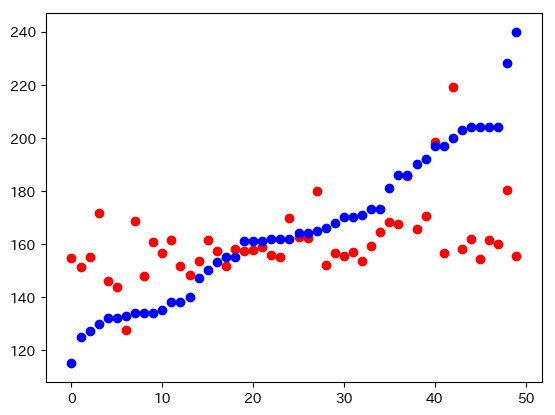

In [57]:
y_pred2 = y_pred.reshape(len(y_pred),)
print(y_pred2.shape)

r1 = np.dot(y_valid-y_pred, y_valid-y_pred)
y_mean = np.ones(len(y_valid))*np.mean(y_valid)
r2 = np.dot(y_valid-y_mean, y_valid-y_mean)
loss = 1 - r1/r2

#loss = np.sqrt(np.dot(y_valid-y_pred, y_valid-y_pred))/len(y_pred)
print(loss)
#y_pred2 = y_pred2[sorted_idx]
#y_valid2 = y_valid[sorted_idx]
length = 50
sorted_idx = np.argsort(y_valid[:length])
#sorted_idx = np.argsort(y_valid[:])
#plt.scatter(range(100), y_pred2[:100], c="r")
#plt.scatter(range(100), y_valid[:100], c="b")
plt.scatter(range(length), y_pred2[sorted_idx], c="r")
plt.scatter(range(length), y_valid[sorted_idx], c="b")
plt.show()


In [21]:

# テストデータについて
# データ読み込み
df_test = pd.read_csv("test.tsv", delimiter='\t')
print("test shape:", df_test.shape)




tstr = str(time.time())

with open(tstr+"_predict.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    for i, pred in zip(idx.astype(int), output.astype(int)):
        writer.writerow([i, pred])


 




(7952, 2048)


C:\Users\keisuke\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


(30000,) (99, 30000)


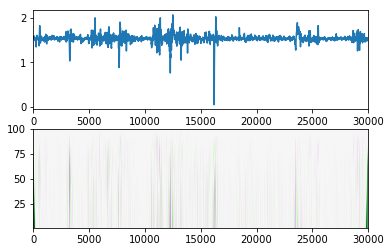

In [41]:

#t = np.linspace(-1, 1, 200, endpoint=False)
t = np.linspace(-1, 1, 200, endpoint=False)

sig  = X_train[np.random.randint(100)]#np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)

plt.subplot(2,1,1)
plt.plot(sig)
plt.xlim(0, len(sig))
max_width = 100
widths = np.arange(1, max_width)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
print(sig.shape, cwtmatr.shape)
plt.subplot(2,1,2)
plt.imshow(cwtmatr, extent=[0, len(sig), 1, max_width], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

C:\Users\keisuke\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(83780, 256)


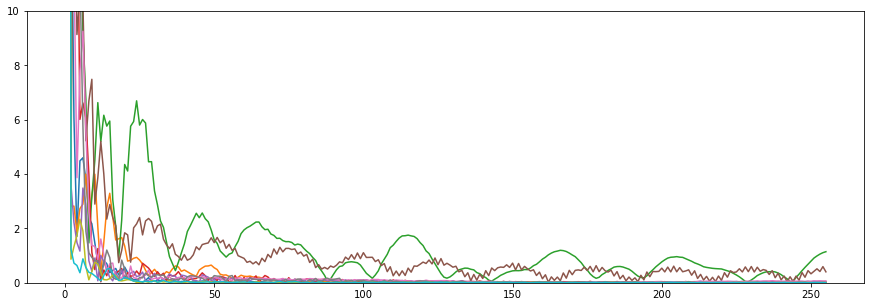

In [5]:


plt.figure(figsize=(15, 5))  

# フーリエ変換
def transform_fft(X, half=False, inv=False):
    X_fft = []
    dim = X.shape[1]
    win = hamming(dim)
    for x in X:
        x = x.reshape(-1,)
        if inv:
            xf = ifft(x)/win 
        else:
            xf = fft(x*win)
            
        if half:
            X_fft.append(np.abs(xf[:dim/2]))
            #xf[dim/2:] = 0
            #X_fft.append(np.abs(xf))
        else:
            X_fft.append(np.abs(xf))
    
    X_fft = np.array(X_fft)
    return X_fft

#print(X_spec.shape)

X_fft_train = transform_fft(X_sub_train, half=True)
print(X_fft_train.shape)

plt.plot(X_fft_train[np.random.randint(0,10000, 10),:].T)
plt.ylim(0,10)
plt.show()


In [12]:
sample_num = X_sub_train.shape[0]
feature_num = 50
X_sub_rs_train = X_sub_train.reshape(sample_num, -1, feature_num)
print(X_sub_rs_train.shape)

(78100, 50, 50)


In [13]:


older_name = dt.now().strftime('%Y-%m-%d-%H-%M-%S')
os.mkdir('./tensorlog/'+folder_name)

filters = 250
kernel_size = 3
hidden_dims = 250

X_dl_train = X_sub_rs_train
y_dl_train = y_sub_train

old_session = KTF.get_session()

with tf.Graph().as_default():
    session = tf.Session('')
    KTF.set_session(session)
    KTF.set_learning_phase(1)

    
    with tf.name_scope("inference") as scope:
        model = Sequential()
        
        model.add(Conv1D(filters, kernel_size, input_dim=X_dl_train.shape[1], padding='valid', activation='relu', strides=1))
        # we use max pooling:
        model.add(GlobalMaxPooling1D())

        # We add a vanilla hidden layer:
        model.add(Dense(hidden_dims))
        model.add(Dropout(0.2))
        model.add(Activation('relu'))

        # We project onto a single unit output layer, and squash it with a sigmoid:
        model.add(Dense(1))

        
        """
        model.add(Dense(50, input_shape=(X_dl_train.shape[1],)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.2))

        model.add(Dense(50))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        model.add(Dense(50))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.5))

        model.add(Dense(1))
        """

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    tb_cb = TensorBoard(log_dir='./tensorlog', histogram_freq=1)
    fpath = './tensorlog/'+folder_name+'/weights-epoch-{epoch:02d}.hdf5'
    cp_cb = ModelCheckpoint(filepath = fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    #es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

    # modelを保存
    model_json_str = model.to_json()
    open('./tensorlog/'+folder_name+'/palse_model.json', 'w').write(model_json_str)
    
    model.fit(X_dl_train, y_sub_train, nb_epoch=1000, batch_size=40, validation_split=0.1, callbacks=[cp_cb, tb_cb])

KTF.set_session(old_session)


Using TensorFlow backend.
C:\Users\keisuke\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(250, 3, padding="valid", activation="relu", strides=1, input_shape=(None, 50))`
C:\Users\keisuke\Anaconda3\lib\site-packages\keras\models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 70290 samples, validate on 7810 samples
INFO:tensorflow:Summary name inference/conv1d_1/kernel:0 is illegal; using inference/conv1d_1/kernel_0 instead.
INFO:tensorflow:Summary name inference/conv1d_1/bias:0 is illegal; using inference/conv1d_1/bias_0 instead.
INFO:tensorflow:Summary name inference/dense_1/kernel:0 is illegal; using inference/dense_1/kernel_0 instead.
INFO:tensorflow:Summary name inference/dense_1/bias:0 is illegal; using inference/dense_1/bias_0 instead.
INFO:tensorflow:Summary name inference/dense_2/kernel:0 is illegal; using inference/dense_2/kernel_0 instead.
INFO:tensorflow:Summary name inference/dense_2/bias:0 is illegal; using inference/dense_2/bias_0 instead.
Epoch 1/1000
70290/70290 [==============================] - 107s - loss: 1264.4827 - acc: 0.0087 - val_loss: 1240.9870 - val_acc: 0.0095
Epoch 2/1000
70290/70290 [==============================] - 98s - loss: 1000.2521 - acc: 0.0094 - val_loss: 1238.5033 - val_acc: 0.0102
Epoch 3/1000
70290/70290 [

KeyboardInterrupt: 

In [61]:


df_test[:5]

test shape: (57, 30001)


,id,V0,V1,V2,V3,V4,V5,V6,V7,V8,...,V29990,V29991,V29992,V29993,V29994,V29995,V29996,V29997,V29998,V29999
0,2,1.546,1.549,1.553,1.554,1.555,1.558,1.559,1.559,1.559,...,1.474,1.477,1.479,1.480,1.481,1.482,1.487,1.494,1.502,1.509
1,5,1.571,1.571,1.571,1.571,1.571,1.571,1.571,1.573,1.573,...,1.555,1.554,1.553,1.553,1.551,1.551,1.552,1.553,1.553,1.553
2,12,1.447,1.444,1.442,1.442,1.445,1.451,1.457,1.464,1.470,...,1.440,1.438,1.435,1.433,1.433,1.433,1.433,1.433,1.431,1.428
3,18,1.507,1.503,1.502,1.500,1.500,1.497,1.496,1.495,1.494,...,1.497,1.498,1.497,1.499,1.500,1.500,1.501,1.502,1.502,1.502
4,19,1.596,1.572,1.546,1.519,1.494,1.475,1.461,1.453,1.449,...,1.486,1.486,1.494,1.503,1.512,1.519,1.523,1.529,1.532,1.534


(57, 30000, 1)
(57, 15001)
(57, 15001)
(57, 57)


C:\Users\keisuke\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


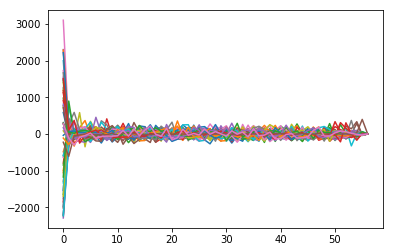

In [68]:
df_test = df_test.replace(0, np.nan)
X_test = zero2median(df_test.values[:,1:]) 

idx = df_test.values[:,0] # 提出用

X_test = X_test.reshape(-1,X_test.shape[1],1)
print(X_test.shape)

X_fft_test = transform_fft(X_test, half=True)
print(X_fft_test.shape)



X_fft_log_test = 20*np.log10(X_fft_test)
print(X_fft_log_test.shape)
# 分析結果を元にデータセットを主成分に変換する
from sklearn.decomposition import PCA
pca_test = PCA(n_components=120)
pca_test.fit(X_fft_log_test)
X_fft_log_pca_test = pca_test.fit_transform(X_fft_log_test)

print(X_fft_log_pca_test.shape)

plt.plot(X_fft_log_pca_test.T)
plt.show()

In [54]:
output = clf.predict(X_fft_log_pca_test)

print(output.shape)


ValueError: X.shape[1] = 57 should be equal to 120, the number of features at training time